In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import pandas.util.testing as tm
import math

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
#https://stackoverflow.com/questions/17211078/how-to-temporarily-modify-sys-path-in-python
#the above link is where i got this code.
#sys.path is restored to original state, after execution of the with statement
#importing sklearn from my directory INSTEAD of /public/apps/etc.etc. because mine is recent version
#apparently, this is called a context manager, visit above link for more explanation
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    sklearn = __import__('sklearn')

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.neural_network import MLPClassifier

In [4]:
#need to double check the preprocessing

ccle_rna_all_genes = pd.read_csv("/home/hshadman/integrins_expression/Integrin_exp_saghar/CCLE/Primary_vs_Metastatsis/ccle_rna_data_sampleinfo_combined_saghar_tentative.csv")



In [5]:
integrin_rna = pd.read_csv('integrins_rna_primary_metastasis.csv', index_col=0)
ccle_sample_info = pd.read_csv('sample_info.csv')
for i in range(3,33):
    intg = integrin_rna.columns[i].split(' ')
    integrin_rna.rename(columns={integrin_rna.columns[i]: intg[0]}, inplace=True)

In [6]:
for primary_dis in integrin_rna.primary_disease.unique():
    print(primary_dis,integrin_rna[integrin_rna.primary_disease==primary_dis].shape)

Lung Cancer (205, 33)
Rhabdoid (19, 33)
Skin Cancer (84, 33)
Bile Duct Cancer (35, 33)
Bladder Cancer (36, 33)
Colon/Colorectal Cancer (70, 33)
Lymphoma (83, 33)
Liposarcoma (10, 33)
Endometrial/Uterine Cancer (40, 33)
Myeloma (30, 33)
Kidney Cancer (37, 33)
Pancreatic Cancer (52, 33)
Brain Cancer (83, 33)
Gastric Cancer (40, 33)
Fibroblast (39, 33)
Breast Cancer (61, 33)
Bone Cancer (39, 33)
Head and Neck Cancer (54, 33)
Ovarian Cancer (64, 33)
Sarcoma (34, 33)
Cervical Cancer (17, 33)
Leukemia (101, 33)
Esophageal Cancer (32, 33)
Liver Cancer (24, 33)
Neuroblastoma (28, 33)
Thyroid Cancer (17, 33)
Gallbladder Cancer (6, 33)
Engineered (14, 33)
Eye Cancer (9, 33)
Embryonal Cancer (1, 33)
Prostate Cancer (11, 33)
Teratoma (1, 33)
Adrenal Cancer (1, 33)


In [22]:
ccle_sample_info_breast = ccle_sample_info[ccle_sample_info["primary_disease"]=="Breast Cancer"]
#ccle_sample_info_breast[[depid for depid in ccle_sample_info_breast['DepMap_ID'] if depid in integrins_rna_breast.index.intersection(pd.Index(ccle_sample_info_breast.DepMap_ID))]]
ccle_sample_info_breast


,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,Achilles_n_replicates,cell_line_NNMD,...,primary_or_metastasis,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype
16,ACH-000017,SK-BR-3,SKBR3,SKBR3_BREAST,NaN,NaN,Female,ATCC,2.0,-2.932250,...,Metastasis,Breast Cancer,Carcinoma,43,SIDM00897,NaN,breast,breast_carcinoma,ERneg_HER2pos,HER2_amp
18,ACH-000019,MCF7,MCF7,MCF7_BREAST,NaN,905946.0,Female,ATCC,2.0,-2.493675,...,Metastasis,Breast Cancer,Carcinoma,69,SIDM00148,NaN,breast,breast_carcinoma,ERpos_HER2neg,luminal
27,ACH-000028,KPL-1,KPL1,KPL1_BREAST,NaN,NaN,Female,DSMZ,3.0,-3.414655,...,Metastasis,Breast Cancer,Carcinoma,50,SIDM00147,NaN,breast,breast_carcinoma,ERpos_HER2neg,luminal
43,ACH-000044,MDA-MB-134-VI,MDAMB134VI,MDAMB134VI_BREAST,NaN,NaN,Female,ATCC,NaN,NaN,...,Metastasis,Breast Cancer,Breast Ductal Carcinoma,47,SIDM00005,NaN,breast,breast_ductal_carcinoma,ERpos_HER2neg,luminal
96,ACH-000097,ZR-75-1,ZR751,ZR751_BREAST,NaN,NaN,Female,ATCC,2.0,-4.290230,...,Metastasis,Breast Cancer,Breast Ductal Carcinoma,63,SIDM00314,NaN,breast,breast_ductal_carcinoma,ERpos_HER2neg,luminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,ACH-002947,NH85TSc p9 2-10-20,NH85TSC,NaN,NaN,NaN,Female,academic Lab,NaN,NaN,...,Primary,Breast Cancer,breast,NaN,NaN,Triple Negative Breast Cancer,Triple Negative Breast Cancer,NaN,NaN,NaN
2898,ACH-002948,NH95T p5 6-18-20,NH95T,NaN,NaN,NaN,Female,academic Lab,NaN,NaN,...,Primary,Breast Cancer,breast,NaN,NaN,Triple Negative Breast Cancer,Triple Negative Breast Cancer,NaN,NaN,NaN
2899,ACH-002949,NH87TT p6 11/26/20,NH87T,NaN,NaN,NaN,Female,academic Lab,NaN,NaN,...,Primary,Breast Cancer,breast,NaN,NaN,Triple Negative Breast Cancer,Triple Negative Breast Cancer,NaN,NaN,NaN
2900,ACH-002950,NH93T p5 4/10/20,NH93T,NaN,NaN,NaN,Female,academic Lab,NaN,NaN,...,Primary,Breast Cancer,breast,NaN,NaN,Triple Negative Breast Cancer,Triple Negative Breast Cancer,NaN,NaN,NaN


In [8]:
integrin_rna

,stripped_cell_line_name,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
ID,,,,,,,,,,,,,,,,,,,,,
ACH-001113,LC1SQSF,Lung Cancer,Primary,1.201634,0.356144,0.150560,6.942632,1.201634,7.129180,3.489286,...,1.049631,6.867032,5.601697,0.070389,0.275007,6.163297,0.000000,8.348551,3.384050,6.162693
ACH-001289,COGAR359,Rhabdoid,NaN,0.097611,0.389567,0.097611,2.863938,0.163499,2.845992,0.485427,...,0.298658,2.226509,2.969012,0.000000,0.000000,1.070389,1.232661,0.485427,1.575312,4.221877
ACH-001339,COLO794,Skin Cancer,Primary,3.030336,1.843984,2.724650,3.087463,0.275007,6.714246,6.428779,...,7.402671,0.526069,7.283459,0.321928,0.250962,4.543496,0.111031,8.570007,4.168321,0.495695
ACH-001538,KKU213,Bile Duct Cancer,Primary,2.087463,0.150560,0.014355,6.875166,0.400538,8.585864,0.000000,...,1.906891,8.704595,4.407353,3.810443,0.070389,1.925999,3.595742,7.946497,4.230357,8.526030
ACH-000242,RT4,Bladder Cancer,Primary,0.263034,0.263034,0.014355,3.770829,0.333424,8.307793,0.042644,...,0.097611,7.891966,4.992315,4.315421,1.214125,1.000000,1.570463,6.135453,6.422569,7.361944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000750,LOXIMVI,Skin Cancer,Metastasis,2.324811,0.432959,0.014355,3.469886,0.238787,8.208429,5.927185,...,0.495695,0.855990,5.391974,0.163499,0.238787,0.137504,0.042644,9.120471,0.464668,0.475085
ACH-000285,TOLEDO,Lymphoma,Primary,0.028569,1.014355,0.111031,0.356144,0.163499,1.257011,5.906410,...,0.389567,1.269033,0.389567,0.070389,2.432959,0.565597,0.163499,6.739308,3.214125,1.077243
ACH-001858,SSP25,Bile Duct Cancer,NaN,1.903038,0.214125,3.705978,2.226509,0.422233,8.307383,1.807355,...,4.361066,5.935460,6.250962,2.440952,0.150560,3.152183,4.552746,9.347356,4.482203,5.086614


In [9]:
integrins_rna_lung = integrin_rna[integrin_rna["primary_disease"]=="Lung Cancer"].copy()
integrins_rna_lung.set_index('stripped_cell_line_name',inplace=True)
integrins_rna_lung=integrins_rna_lung.dropna(axis=0,how='any').copy()
integrins_rna_lung

,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,ITGA5,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
LC1SQSF,Lung Cancer,Primary,1.201634,0.356144,0.150560,6.942632,1.201634,7.129180,3.489286,3.935460,...,1.049631,6.867032,5.601697,0.070389,0.275007,6.163297,0.000000,8.348551,3.384050,6.162693
NCIH1395,Lung Cancer,Primary,1.327687,0.963474,0.084064,2.007196,1.201634,5.358959,0.124328,2.134221,...,0.056584,2.392317,5.885086,0.978196,1.070389,3.455492,0.028569,4.299391,4.753818,8.602142
LC1F,Lung Cancer,Primary,1.367371,0.189034,0.028569,5.081084,1.782409,7.034744,0.238787,3.235727,...,0.678072,7.677649,5.284662,0.150560,0.367371,4.718636,0.042644,9.394763,4.074677,8.277938
ABC1,Lung Cancer,Metastasis,0.356144,0.084064,0.070389,2.750607,1.176323,3.604071,0.042644,0.985500,...,0.042644,6.451211,5.017477,0.056584,0.378512,2.841973,0.028569,1.077243,5.934988,9.467361
LK2,Lung Cancer,Primary,1.384050,0.201634,0.201634,2.046142,0.622930,1.769772,0.124328,0.678072,...,0.097611,3.939227,4.031219,0.286881,0.475085,1.070389,0.084064,7.350851,3.367371,9.221200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH23,Lung Cancer,Primary,1.063503,0.298658,0.056584,4.762349,2.510962,5.048759,0.389567,4.745775,...,0.782409,1.891419,4.925525,0.137504,0.432959,1.226509,1.867896,5.829596,3.240314,2.427606
NCIH1355,Lung Cancer,Metastasis,2.025029,0.604071,0.056584,2.488001,0.933573,7.713558,1.321928,6.082362,...,0.956057,6.174926,8.641402,0.201634,0.978196,3.260026,0.137504,8.756957,5.636625,5.999098
NCIH2405,Lung Cancer,Metastasis,4.868884,4.336997,1.613532,5.421897,1.150560,9.452571,3.662205,6.848623,...,3.683696,8.247121,7.453271,4.316146,0.847997,3.665620,5.479619,9.971687,5.731183,6.601102


In [10]:
integrins_rna_colorectal = integrin_rna[integrin_rna["primary_disease"]=="Colon/Colorectal Cancer"].copy()
integrins_rna_colorectal.set_index('stripped_cell_line_name',inplace=True)
integrins_rna_colorectal=integrins_rna_colorectal.dropna(axis=0,how='any').copy()
integrins_rna_colorectal


,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,ITGA5,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
SNU283,Colon/Colorectal Cancer,Metastasis,0.722466,0.176323,0.238787,2.757023,0.014355,4.945327,0.070389,0.464668,...,0.176323,6.588865,5.621173,2.316146,0.432959,2.353323,0.189034,7.564073,5.487036,9.742663
TGBC18TKB,Colon/Colorectal Cancer,Primary,1.782409,0.137504,0.201634,6.112075,0.333424,8.509300,0.014355,0.963474,...,0.150560,8.215484,5.494736,6.146289,0.632268,3.438293,1.974529,8.528454,8.038754,9.145397
SW837,Colon/Colorectal Cancer,Primary,1.000000,0.028569,0.321928,5.286512,1.516015,7.182593,0.495695,2.853996,...,0.526069,7.379552,6.333424,3.200065,1.937344,2.729009,0.495695,5.253611,6.043738,9.183883
HT29,Colon/Colorectal Cancer,Primary,3.218781,0.070389,0.014355,3.291309,0.014355,5.781884,0.084064,0.070389,...,0.042644,6.773733,6.837565,3.104337,2.007196,2.195348,0.014355,8.105123,5.854494,8.729417
LS123,Colon/Colorectal Cancer,Primary,0.985500,0.356144,0.028569,4.669027,0.333424,6.749802,0.150560,4.407353,...,0.042644,6.768052,6.745775,2.014355,1.655352,3.852998,6.872706,6.766728,4.856986,7.830230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LS411N,Colon/Colorectal Cancer,Primary,0.555816,0.933573,0.111031,4.025029,0.214125,4.923149,0.238787,0.613532,...,0.056584,6.101398,5.027685,1.263034,1.757023,2.263034,0.084064,8.410409,5.258896,9.080711
SW626,Colon/Colorectal Cancer,Metastasis,5.196135,0.275007,0.000000,3.988230,0.124328,5.917670,0.014355,2.464668,...,0.028569,6.916357,6.159266,4.662205,1.327687,3.311794,1.042644,7.583459,5.276497,9.292161
COLO678,Colon/Colorectal Cancer,Metastasis,0.238787,0.731183,0.111031,3.176323,1.929791,9.035486,0.056584,2.961623,...,0.150560,8.919727,7.697732,4.876271,1.613532,0.963474,0.028569,3.323370,8.287943,8.092704


In [11]:
integrins_rna_skin = integrin_rna[integrin_rna["primary_disease"]=="Skin Cancer"].copy()
integrins_rna_skin.set_index('stripped_cell_line_name',inplace=True)
integrins_rna_skin=integrins_rna_skin.dropna(axis=0,how='any').copy()
integrins_rna_skin


,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,ITGA5,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
COLO794,Skin Cancer,Primary,3.030336,1.843984,2.724650,3.087463,0.275007,6.714246,6.428779,6.374170,...,7.402671,0.526069,7.283459,0.321928,0.250962,4.543496,0.111031,8.570007,4.168321,0.495695
WM983B,Skin Cancer,Metastasis,3.001802,0.454176,0.333424,2.592158,0.464668,6.326609,6.501439,5.395748,...,6.761551,1.580145,7.222167,0.275007,0.748461,5.690417,0.485427,8.707808,5.773469,1.956057
SKMEL1,Skin Cancer,Metastasis,2.553361,6.081723,0.124328,1.280956,1.226509,4.087463,1.443607,0.963474,...,6.809672,2.084064,5.569552,0.070389,0.575312,0.516015,2.232661,9.055770,1.250962,0.765535
IGR39,Skin Cancer,Primary,2.847997,0.321928,4.541019,4.887038,1.014355,8.330245,5.348374,6.763013,...,3.804260,2.794936,8.656711,0.226509,0.443607,2.400538,1.070389,9.861258,4.867402,0.704872
HT144,Skin Cancer,Metastasis,4.003602,2.232661,2.324811,3.785551,0.378512,7.470211,6.185272,7.051807,...,7.383445,0.475085,7.937697,0.042644,0.189034,4.485427,0.555816,9.336261,4.731183,0.575312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SKMEL31,Skin Cancer,Primary,5.559492,3.065228,5.275007,4.676380,0.422233,8.708808,5.739038,6.111866,...,7.872275,1.794936,8.699087,0.669027,1.350497,3.904966,0.378512,10.005484,4.906410,1.169925
UACC257,Skin Cancer,Primary,1.906891,2.283922,0.056584,1.049631,0.356144,4.667892,3.393691,1.933573,...,5.297558,1.937344,6.277427,0.150560,2.459432,3.554589,0.097611,8.144862,4.184280,0.516015
A2058,Skin Cancer,Metastasis,5.142005,1.739848,0.584963,3.367371,0.275007,7.099716,4.134221,5.372256,...,6.090007,2.280956,7.207210,0.124328,0.757023,4.349082,0.097611,8.209112,4.754888,0.555816


In [12]:
integrins_rna_brain = integrin_rna[integrin_rna["primary_disease"]=="Brain Cancer"].copy()
integrins_rna_brain.set_index('stripped_cell_line_name',inplace=True)
integrins_rna_brain=integrins_rna_brain.dropna(axis=0,how='any').copy()
integrins_rna_brain


,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,ITGA5,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
YKG1,Brain Cancer,Primary,6.997744,4.469886,2.931683,5.133810,0.903038,7.722261,1.384050,6.688320,...,2.361768,1.906891,7.719047,0.056584,0.263034,5.461398,3.404631,8.687306,3.679199,1.049631
U87MG,Brain Cancer,Primary,2.432959,1.298658,3.970854,5.355087,0.111031,9.636498,2.280956,8.881145,...,6.341274,1.063503,6.777420,0.097611,0.485427,1.195348,5.667041,9.747119,2.185867,0.903038
AM38,Brain Cancer,Primary,2.025029,1.827819,0.124328,3.626439,0.722466,9.162240,3.901108,5.842979,...,1.555816,0.389567,3.956057,0.042644,1.516015,0.400538,1.490570,9.813124,3.820690,0.739848
TASK1,Brain Cancer,Primary,0.575312,0.298658,0.097611,0.536053,0.839960,0.545968,0.310340,4.426936,...,0.014355,1.713696,5.329124,0.000000,0.084064,0.000000,0.000000,2.543496,3.978196,2.035624
SF295,Brain Cancer,Primary,3.258519,0.678072,2.538538,5.348374,0.432959,9.171827,4.866413,8.227520,...,3.385431,1.372952,7.146492,0.137504,0.310340,2.140779,5.379898,10.812739,4.583760,0.839960
SNU1105,Brain Cancer,Primary,2.757023,1.238787,6.844737,2.353323,0.485427,9.375365,5.149341,9.307064,...,4.784504,1.510962,8.324766,0.475085,0.495695,4.982765,1.678072,9.144352,4.934045,0.505891
NP8,Brain Cancer,Primary,3.223423,0.695994,6.413628,2.863938,0.189034,9.046415,3.909773,8.336194,...,1.356144,2.641546,7.834787,1.070389,0.084064,3.258519,0.970854,8.811824,4.384741,0.097611
GAMG,Brain Cancer,Primary,3.063503,1.333424,3.658783,5.232661,0.378512,9.639250,3.418190,7.805679,...,5.665904,1.811471,7.827629,0.575312,0.310340,1.021480,4.493135,10.814903,4.032982,0.695994
NP5,Brain Cancer,Primary,4.355439,1.773996,7.633940,4.358959,1.333424,6.213930,4.355439,7.832510,...,2.615887,2.104337,8.834313,0.084064,0.565597,1.454176,3.087463,5.380937,1.646163,0.189034


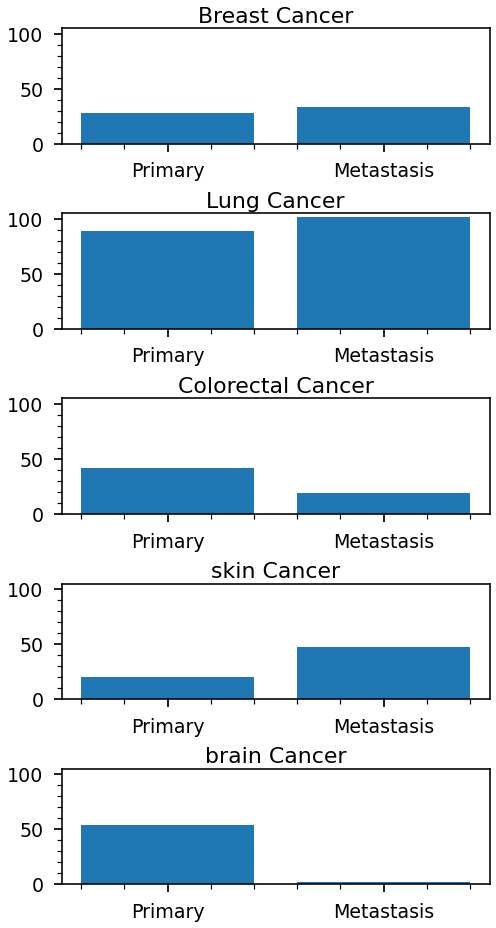

In [28]:
breast_primary_metastasis_status = np.flip(integrins_rna_breast.primary_or_metastasis.unique())
lung_primary_metastasis_status = integrins_rna_lung.primary_or_metastasis.unique()
colorectal_primary_metastasis_status = np.flip(integrins_rna_colorectal.primary_or_metastasis.unique())
skin_primary_metastasis_status = integrins_rna_skin.primary_or_metastasis.unique()
brain_primary_metastasis_status = integrins_rna_brain.primary_or_metastasis.unique()

fig, ax = plt.subplots(nrows=5,ncols=1, figsize=(7,13))
ax[0].bar(breast_primary_metastasis_status,
          np.array([integrins_rna_breast[integrins_rna_breast.primary_or_metastasis==breast_primary_metastasis_status[0]].shape[0],
                    integrins_rna_breast[integrins_rna_breast.primary_or_metastasis==breast_primary_metastasis_status[1]].shape[0]]))
ax[0].set_title('Breast Cancer', fontsize = 22)
ax[0].set_ylim(0,105)

ax[1].bar(lung_primary_metastasis_status,
          np.array([integrins_rna_lung[integrins_rna_lung.primary_or_metastasis==lung_primary_metastasis_status[0]].shape[0],
                    integrins_rna_lung[integrins_rna_lung.primary_or_metastasis==lung_primary_metastasis_status[1]].shape[0]]))
ax[1].set_title('Lung Cancer', fontsize = 22)
ax[1].set_ylim(0,105)

ax[2].bar(colorectal_primary_metastasis_status,
          np.array([integrins_rna_colorectal[integrins_rna_colorectal.primary_or_metastasis==colorectal_primary_metastasis_status[0]].shape[0],
                    integrins_rna_colorectal[integrins_rna_colorectal.primary_or_metastasis==colorectal_primary_metastasis_status[1]].shape[0]]))
ax[2].set_title('Colorectal Cancer', fontsize = 22)
ax[2].set_ylim(0,105)

ax[3].bar(skin_primary_metastasis_status,
          np.array([integrins_rna_skin[integrins_rna_skin.primary_or_metastasis==skin_primary_metastasis_status[0]].shape[0],
                    integrins_rna_skin[integrins_rna_skin.primary_or_metastasis==skin_primary_metastasis_status[1]].shape[0]]))
ax[3].set_title('skin Cancer', fontsize = 22)
ax[3].set_ylim(0,105)

ax[4].bar(brain_primary_metastasis_status,
          np.array([integrins_rna_brain[integrins_rna_brain.primary_or_metastasis==brain_primary_metastasis_status[0]].shape[0],
                    integrins_rna_brain[integrins_rna_brain.primary_or_metastasis==brain_primary_metastasis_status[1]].shape[0]]))
ax[4].set_title('brain Cancer', fontsize = 22)
ax[4].set_ylim(0,105)


for axs in ax.ravel():
    plt.setp(axs.get_xticklabels(),fontsize=19)
    plt.setp(axs.get_yticklabels(),fontsize=19)
    #axs.set_ylim(0.8,1)
    for i in ['top', 'left', 'right', 'bottom']:
        axs.spines[i].set_linewidth(1.6)

    axs.minorticks_on()
    axs.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
    axs.tick_params(axis='both', which='minor', width = 1.2, size = 5)    

plt.tight_layout()


In [14]:
integrins_rna_breast = integrin_rna[integrin_rna["primary_disease"]=="Breast Cancer"].copy()
integrins_rna_breast#.set_index('stripped_cell_line_name',inplace=True)
integrins_rna_breast

,stripped_cell_line_name,primary_disease,primary_or_metastasis,ITGA1,ITGA10,ITGA11,ITGA2,ITGA2B,ITGA3,ITGA4,...,ITGB3,ITGB4,ITGB5,ITGB6,ITGB7,ITGB8,ITGBL1,CD44,ERBB2,EPCAM
ID,,,,,,,,,,,,,,,,,,,,,
ACH-000828,ZR7530,Breast Cancer,Metastasis,0.014355,2.046142,0.028569,1.604071,0.389567,4.553361,0.042644,...,0.150560,4.606442,7.654708,3.066950,0.536053,0.056584,0.056584,5.469560,11.437388,7.190319
ACH-000117,EFM192A,Breast Cancer,Metastasis,0.310340,0.526069,0.014355,1.310340,0.704872,5.718362,0.189034,...,0.150560,4.785027,5.088735,1.084064,1.879706,0.321928,0.124328,4.010780,11.436035,7.317232
ACH-000017,SKBR3,Breast Cancer,Metastasis,0.526069,0.163499,0.084064,1.263034,0.659925,3.708187,0.124328,...,0.070389,4.319040,7.204082,3.438293,0.214125,0.137504,0.056584,1.985500,10.844706,7.035294
ACH-000554,UACC893,Breast Cancer,Primary,0.070389,0.475085,0.124328,2.906891,0.014355,5.942984,0.201634,...,0.111031,6.836177,7.076816,5.200457,0.226509,0.070389,0.084064,3.035624,11.648582,9.178466
ACH-000276,HCC38,Breast Cancer,Primary,1.250962,0.422233,0.389567,4.240314,2.370164,7.142720,4.936873,...,5.000451,5.739308,7.382148,7.287989,0.757023,3.636915,1.851999,8.722193,7.115408,8.790739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000097,ZR751,Breast Cancer,Metastasis,0.111031,1.077243,0.163499,2.704872,2.289834,5.074249,0.310340,...,0.464668,4.779785,4.296457,2.257011,1.244887,0.536053,0.389567,4.678635,6.756623,7.933868
ACH-000288,BT549,Breast Cancer,Primary,0.124328,3.054848,0.464668,0.321928,0.641546,6.630522,3.420887,...,0.855990,0.941106,5.025472,0.070389,0.070389,1.974529,2.028569,10.035486,4.135863,0.956057
ACH-001820,COLO824,Breast Cancer,Metastasis,0.084064,1.454176,0.454176,3.058316,0.111031,2.127633,0.963474,...,0.042644,4.133399,3.527321,0.097611,0.056584,4.228819,0.042644,9.311612,6.770036,9.385755


# t-sne

this is practice dataset IRIS
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.509910


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.387627
[t-SNE] KL divergence after 1000 iterations: 0.129141


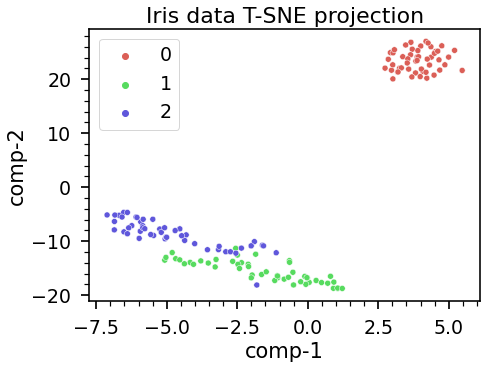

In [37]:
#first a little practice
print('this is practice dataset IRIS')
fig, ax = plt.subplots (figsize = (7,5))
iris = load_iris()
x = iris.data
y = iris.target 


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)


df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),ax=ax,
                data=df).axes.set_title("Iris data T-SNE projection",fontsize=22) 

plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax.legend(fontsize=19)

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 460 samples in 0.000s...
[t-SNE] Computed neighbors for 460 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 2.959738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.788940
[t-SNE] KL divergence after 1000 iterations: 0.827095
all genes


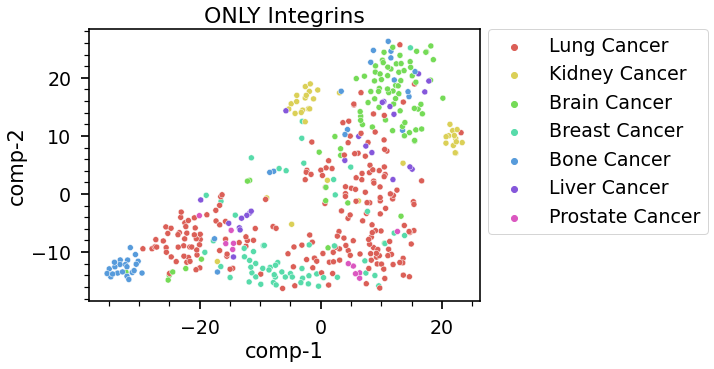

In [40]:
fig, ax = plt.subplots (figsize = (7,5))
#Lets see if integrins alone can cluster primary_disease
data = integrin_rna.copy()
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Kidney Cancer')|(data.primary_disease=='Prostate Cancer')|(data.primary_disease=='Liver Cancer')|(data.primary_disease=='Brain Cancer')|(data.primary_disease=='Lung Cancer')|(data.primary_disease=='Bone Cancer')]
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 159 samples in 0.000s...
[t-SNE] Computed neighbors for 159 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 159 / 159
[t-SNE] Mean sigma: 3.280770
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.378162
[t-SNE] KL divergence after 800 iterations: 0.485009


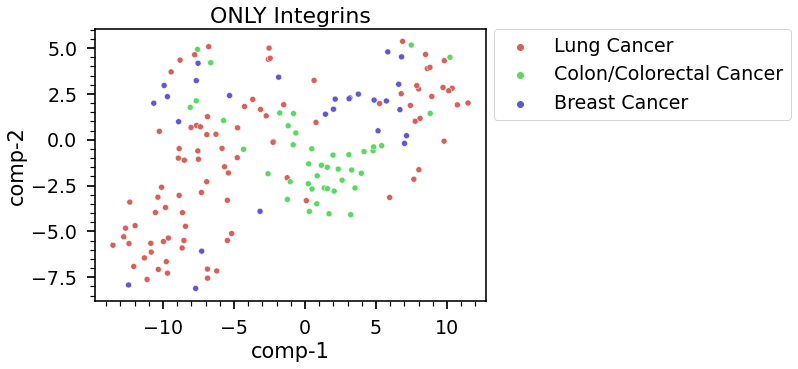

In [42]:
fig, ax = plt.subplots (figsize = (7,5))
#Lets see if integrins alone can cluster primary_disease

#data = data[data.primary_or_metastasis=="Primary"]
data = integrin_rna.copy()
data = data[data.primary_or_metastasis=="Primary"]
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Lung Cancer')|(data.primary_disease=='Colon/Colorectal Cancer')]
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1377 samples in 0.000s...
[t-SNE] Computed neighbors for 1377 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1377
[t-SNE] Computed conditional probabilities for sample 1377 / 1377
[t-SNE] Mean sigma: 2.587031
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.364281
[t-SNE] KL divergence after 1000 iterations: 1.045525


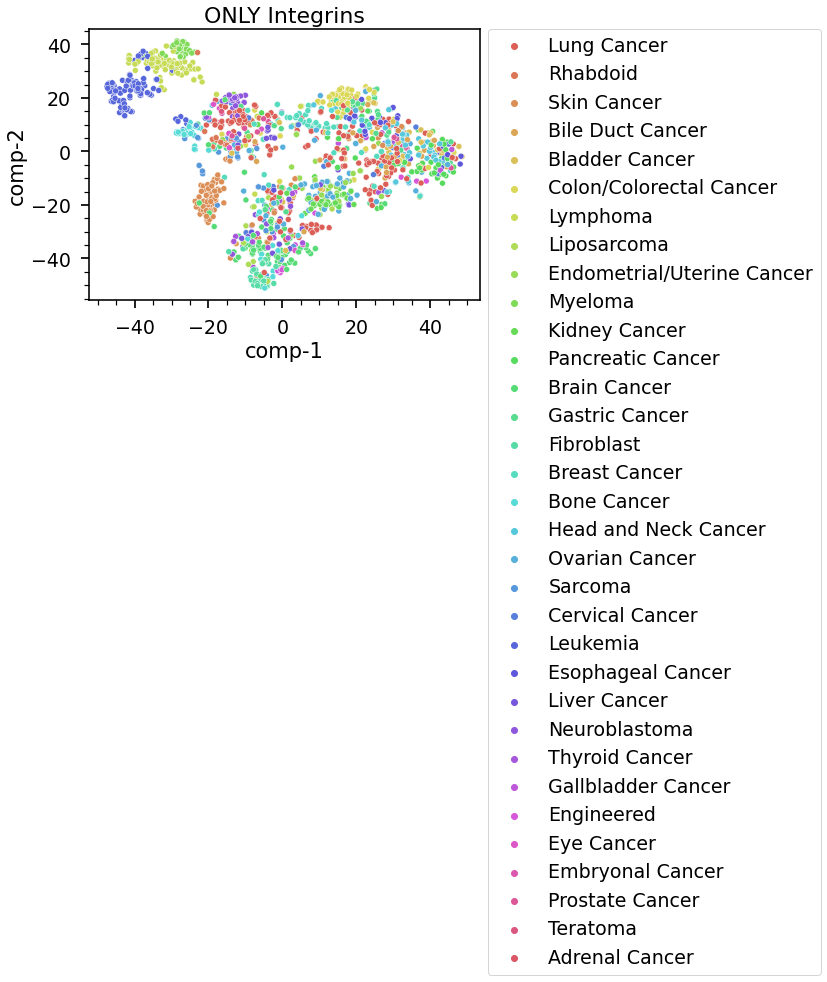

In [43]:
fig, ax = plt.subplots (figsize = (7,5))
#Lets see if integrins alone can cluster primary_disease

#data = data[data.primary_or_metastasis=="Primary"]
data = integrin_rna.copy()
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1377 samples in 0.020s...
[t-SNE] Computed neighbors for 1377 samples in 0.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1377
[t-SNE] Computed conditional probabilities for sample 1377 / 1377
[t-SNE] Mean sigma: 45.005817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.411186
[t-SNE] KL divergence after 1000 iterations: 0.870742


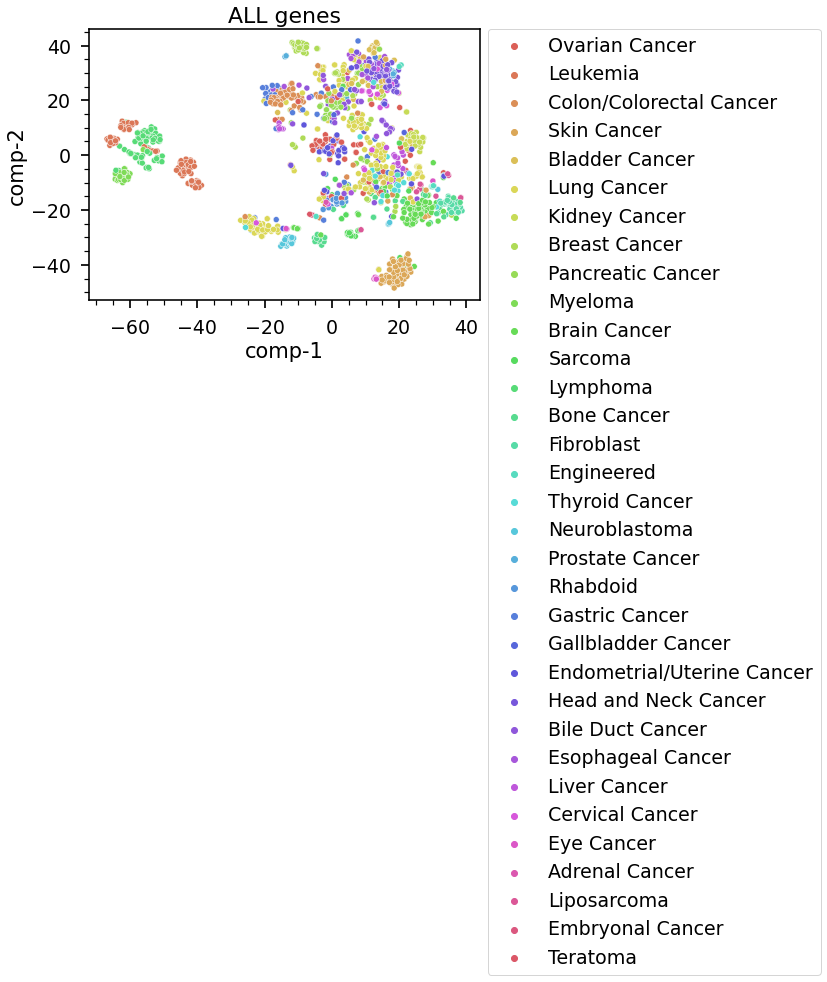

In [54]:
fig, ax = plt.subplots (figsize = (7,5))
#Lets see if all genes

data = ccle_rna_all_genes.copy()
#must be careful with the column numbers (col 7 and onwards are genes)
x = data.iloc[:,7:]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ALL genes",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


In [55]:
#double check that 7: consists of ONLY genes
ccle_rna_all_genes.iloc[:,7:]

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,ARHGAP11B (89839),AC004593.2 (1124),AC090517.4 (54816),AL160269.1 (11046),ABCF2-H2BE1 (114483834),POLR2J3 (548644),H2BE1 (114483833),AL445238.1 (647264),GET1-SH3BGR (106865373),AC113348.1 (102724657)
0,5.823495,0.000000,7.369292,2.100978,4.221877,0.042644,0.910733,5.672991,4.676380,4.013462,...,1.545968,0.189034,0.275007,0.000000,0.545968,4.424922,0.000000,0.000000,0.124328,0.000000
1,0.189034,0.000000,5.633431,1.263034,3.152183,4.189034,0.163499,4.161888,4.139961,2.799087,...,1.761285,0.000000,0.056584,0.000000,0.799087,3.748461,0.000000,0.000000,0.189034,0.000000
2,6.035624,0.084064,7.744767,1.851999,3.895303,0.000000,0.056584,6.597978,4.734981,4.141596,...,1.895303,0.344828,0.042644,0.028569,2.914565,5.350144,0.111031,0.000000,0.070389,0.000000
3,2.599318,0.000000,5.310340,2.467279,3.926948,0.918386,4.957915,3.912650,4.878725,4.971314,...,2.704872,0.286881,0.070389,0.454176,2.257011,6.182692,0.000000,0.000000,0.782409,0.000000
4,3.051372,0.000000,5.754888,2.969012,5.322289,0.214125,5.762880,4.152995,5.532629,5.330558,...,2.580145,0.454176,0.137504,0.084064,1.560715,5.469886,0.000000,0.000000,0.042644,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,5.556736,0.000000,6.861955,2.220330,2.843984,0.014355,4.788164,5.529509,4.036503,3.463361,...,1.485427,0.000000,0.176323,0.000000,2.056584,3.777157,0.000000,0.000000,0.286881,0.000000
1373,5.548128,0.344828,6.132166,3.249445,4.156235,0.000000,1.981853,5.844737,3.471187,4.622345,...,0.948601,0.014355,0.275007,0.000000,0.807355,5.042644,0.000000,0.000000,1.422233,0.000000
1374,4.052242,0.000000,6.295539,1.922198,2.364572,0.000000,1.495695,6.338424,3.768714,4.216455,...,0.176323,0.028569,0.042644,0.028569,2.456806,5.454505,0.000000,0.042644,1.454176,0.042644
1375,3.727920,0.000000,7.306335,2.833902,3.942984,0.400538,1.843984,4.697107,4.454176,4.144046,...,0.632268,0.028569,0.111031,0.028569,1.570463,4.254745,0.000000,0.000000,0.855990,0.000000


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 460 samples in 0.007s...
[t-SNE] Computed neighbors for 460 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 47.174422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.879776
[t-SNE] KL divergence after 1000 iterations: 0.663997


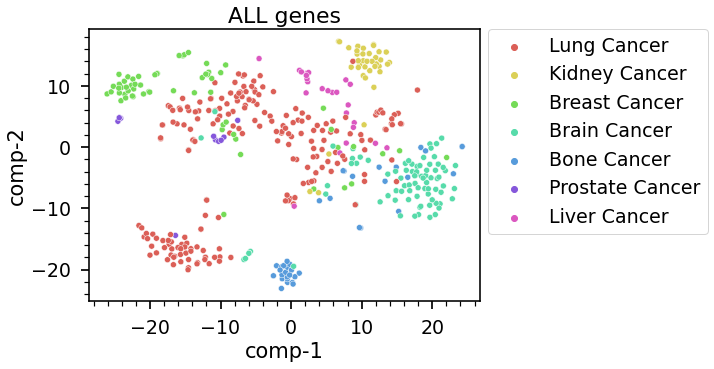

In [56]:
fig, ax = plt.subplots (figsize = (7,5))
#Lets see if all genes

data = ccle_rna_all_genes.copy()

data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Kidney Cancer')|(data.primary_disease=='Prostate Cancer')|(data.primary_disease=='Liver Cancer')|(data.primary_disease=='Brain Cancer')|(data.primary_disease=='Lung Cancer')|(data.primary_disease=='Bone Cancer')]
x = data.iloc[:,7:]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ALL genes",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 460 samples in 0.000s...
[t-SNE] Computed neighbors for 460 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 2.959738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.788940
[t-SNE] KL divergence after 1000 iterations: 0.827095


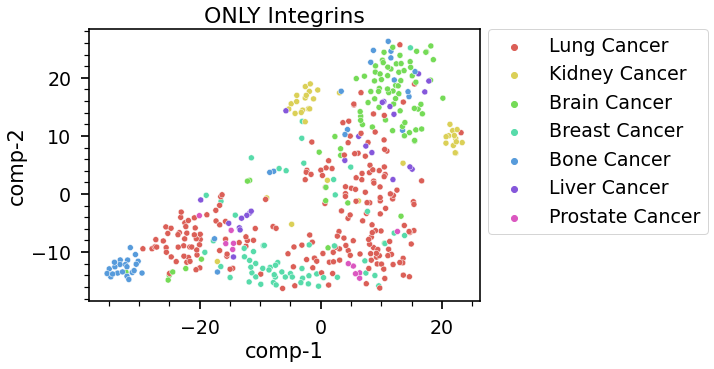

In [57]:
fig, ax = plt.subplots (figsize = (7,5))

data = integrin_rna.copy()
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Kidney Cancer')|(data.primary_disease=='Prostate Cancer')|(data.primary_disease=='Liver Cancer')|(data.primary_disease=='Brain Cancer')|(data.primary_disease=='Lung Cancer')|(data.primary_disease=='Bone Cancer')]
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 438 samples in 0.007s...
[t-SNE] Computed neighbors for 438 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 438 / 438
[t-SNE] Mean sigma: 56.357274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.729511
[t-SNE] KL divergence after 1000 iterations: 0.348693


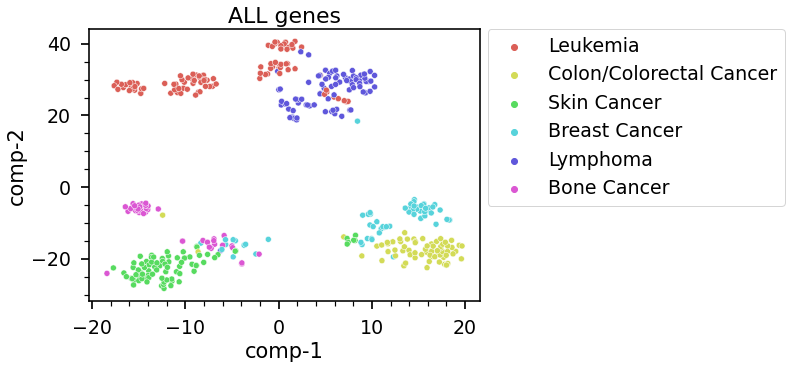

In [58]:
fig, ax = plt.subplots (figsize = (7,5))

data = ccle_rna_all_genes.copy()
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Bone Cancer')|(data.primary_disease=='Colon/Colorectal Cancer')|(data.primary_disease=='Lymphoma')|(data.primary_disease=='Leukemia')|(data.primary_disease=='Skin Cancer')]
x = data.iloc[:,7:]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ALL genes",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 438 samples in 0.000s...
[t-SNE] Computed neighbors for 438 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 438 / 438
[t-SNE] Mean sigma: 3.405915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.526974
[t-SNE] KL divergence after 1000 iterations: 0.486083


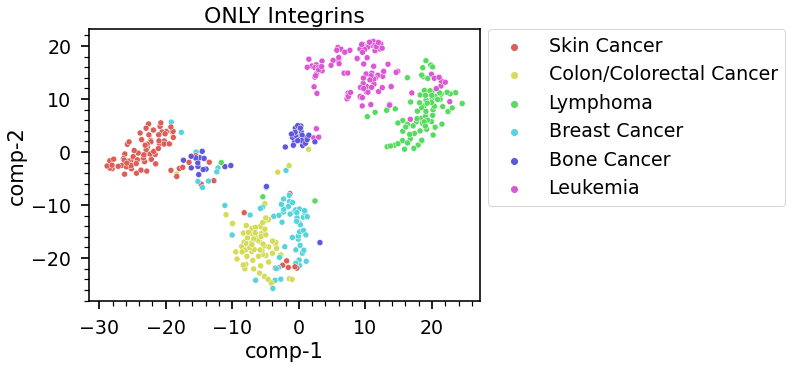

In [59]:
fig, ax = plt.subplots (figsize = (7,5))

data = integrin_rna.copy()
#data = data[data.primary_or_metastasis=="Primary"]
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Bone Cancer')|(data.primary_disease=='Colon/Colorectal Cancer')|(data.primary_disease=='Lymphoma')|(data.primary_disease=='Leukemia')|(data.primary_disease=='Skin Cancer')]
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


In [ ]:
fig, ax = plt.subplots (figsize = (7,5))

data = integrin_rna.copy()
data = data[(data.primary_disease=='Breast Cancer')|(data.primary_disease=='Skin Cancer')|(data.primary_disease=='Colon/Colorectal Cancer')]
x = data.iloc[:,data.columns.str.contains("ITG")]
y = data.primary_disease


tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                 palette=sns.color_palette("hls", len(df.y.unique())),ax=ax,
                 data=df).axes.set_title("ONLY Integrins",fontsize=22)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=19)
plt.setp(ax.get_xticklabels(),fontsize=19)
plt.setp(ax.get_yticklabels(),fontsize=19)
ax.set_xlabel('comp-1',fontsize=21)
ax.set_ylabel('comp-2',fontsize=21)
#ax.set_ylim(0.8,1)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 215 samples in 0.000s...
[t-SNE] Computed neighbors for 215 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 215 / 215
[t-SNE] Mean sigma: 3.158879
